# Bonding Curve Experiments

This demo is based off of Dr. Zargham's [Economic Games as Estimators](https://epub.wu.ac.at/7433/) paper. It's abstract is as follows:

Discrete event games are discrete time dynamical systems whose state transitions are discrete events caused by actions taken by agents within the game. The agents’ objectives and associated decision rules need not be known to the game designer in order to impose struc- ture on a game’s reachable states. Mechanism design for discrete event games is accomplished by declaring desirable invariant properties and restricting the state transition functions to conserve these properties at every point in time for all admissible actions and for all agents, using techniques familiar from state-feedback control theory. Building upon these connections to control theory, a framework is developed to equip these games with estimation properties of signals which are private to the agents playing the game. Token bonding curves are presented as discrete event games and numerical experiments are used to investigate their signal processing properties with a focus on input-output response dynamics.

The whole paper is highly recommended and will enhance understanding of demo below. This notebook contains both experiments run in section 4, beginning page 14. The *Price Estimator Response Dynamics* section does not contain any monte carlo runs while *Price Estimator Response Dynamics Parameter Sweep* contains 10 monte carlo runs. Both have 4,000 timesteps.


## Model File structure
* Bonding_Curve.ipynb
* model - Price Estimator Response Dynamics simulations
* model_param - Price Estimator Response Dynamics Parameter Sweep simulations

In each model folder there exist 4 files and a parts folder (all links are for the model folder), the [config.py](model/config.py), [partial_state_update_block.py](model/partial_state_update_block.py), [run.py](model/run.py), and [state_variables.py](state_variables.py). The [config.py](model/config.py) contains the simulation configurations, aggregating the partial states, and the state variables. The [partial_state_update_block.py](model/partial_state_update_block.py) contains the partial state update blocks and how they update the state variables. [state_variables.py](state_variables.py) defines the state variables and [run.py](model/run.py) actually runs the simulation. 

The components of the model live within the parts subfolder as:

* [system.py](model/parts/system.py)
* [utils.py](model/parts/utils.py)

The initial parameters and hyperparameters of the system are defined in [sys_params.py](model/sys_params.py) and helper functions, plots, etc. are in the [utils.py](model/parts/utils.py).


## Price Estimator Response Dynamics 

To illustrate the impact on $P_t$ of different driving processes, three deterministic signals are defined: a Square-Wave, a Triangle-Wave and a Sine-Wave. To capture stochastic effects, a Martingale stochastic process is also introduced. These simple signals abstract away from the complexity of possible inputs $\hat P_t$, while simultaneously acting as a starting point for the analysis of a broad range of feedback mechanisms caused by a closed-loop game. The determinstic signals can be characterized by wavelength $\lambda$, amplitude $A$ and phase $\phi$, for time $t\in\{0,\ldots 4000\}$, and are described using the functional forms in Table 1.

Our experiments use the bonding curvature parameter $\kappa =2$ and the system is initialized with a community token supply $S_0=1000000$ and reserve currency units $R_0=50000$, resulting in an initial price $P_0=0.10$ reserve units per token and an invariant $\bar V=V_0=20000000$.  The deterministic driving functions are taken with $\phi=0$, $B=P_0$ and $\lambda =2000$. Amplitude $A$ takes values $\frac{P_0}{2}$, $\frac{P_0}{100}$, and $\frac{P_0}{2}$ for the Square-Wave, Triangle-Wave and Sine-Wave, respectively. For the Random Walk, an initial condition $\hat P_0 = P_0$ is applied, and the percent change in $\hat P_0$ is drawn from a Gaussian distribution with mean $\mu =0$ and variance $\sigma=0.05$.

In [1]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
import seaborn as sns

%matplotlib inline

from model import run 
from model.parts.utils import response_plot

df = run.run()
rdf = run.postprocessing(df)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (4000, 9, 4, 5)
Execution Method: local_simulations
SimIDs   : [0, 0, 0, 0]
SubsetIDs: [0, 1, 2, 3]
Ns       : [0, 1, 2, 3]
ExpIDs   : [0, 0, 0, 0]
Execution Mode: parallelized
Total execution time: 1.50s


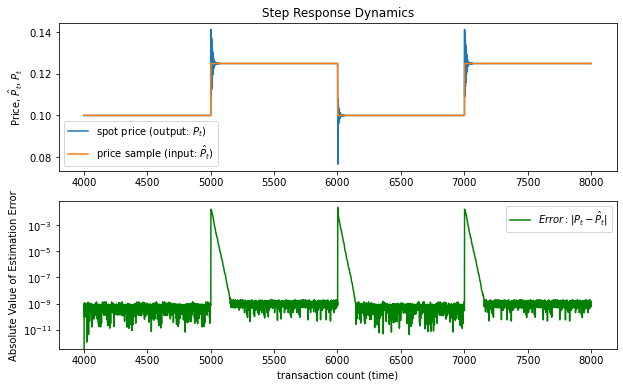

In [2]:
response_plot(rdf[rdf.rule=='step'], "Step")

The Square-Wave response above shows that the step response is tightly tuned, resulting in a large overshoot but remaining stable, oscillating and converging quickly. This behavior is characteristic of a high gain proportional controller. 

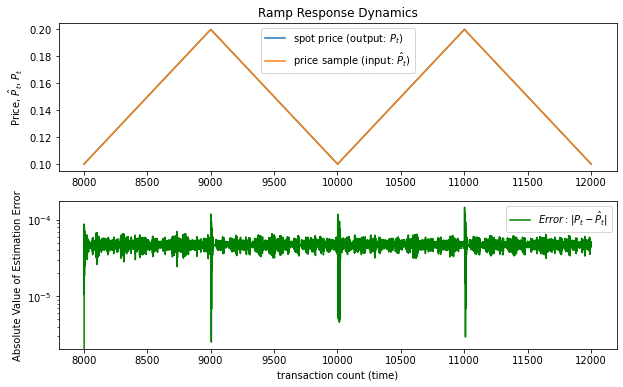

In [3]:
response_plot(rdf[rdf.rule=='ramp'], "Ramp")

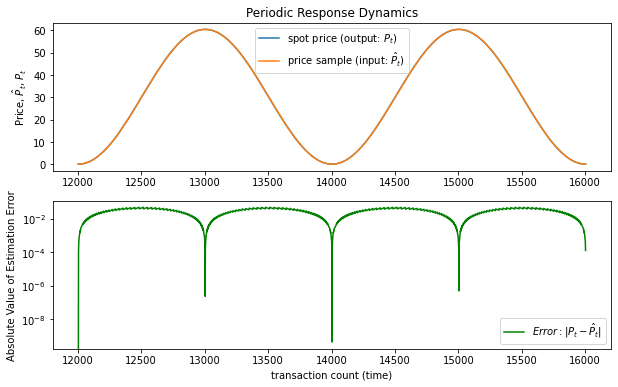

In [4]:
response_plot(rdf[rdf.rule=='sin'], "Periodic")

The Triangle-Wave and Sine-Wave signals are equally reminiscent of such a controller; the Triangle-Wave exhibits steady state error during the ramp and the Sine-Wave tracks most closely at the peaks and troughs.

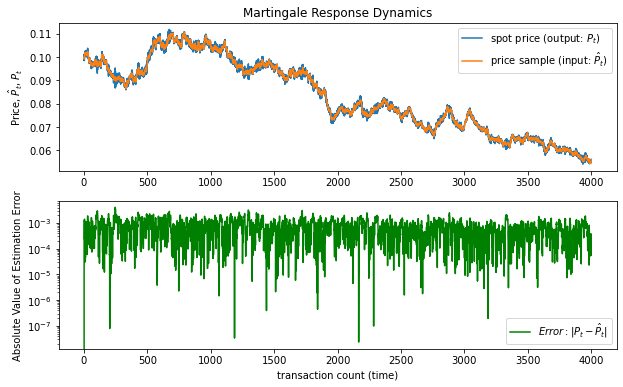

In [5]:
response_plot(rdf[rdf.rule=='martin'], "Martingale")

In the Random Walk tracking behavior is observed, but the error radius appears large. Despite the high frequency noise, the error does not appear to accumulate, and does appear to remain within a ball roughly on the order of $3\sigma$, likely an artifact of the random walk whereby $\frac{\Delta \hat P_t}{\hat P_t} \sim N(0,\sigma)$ for all $t$.

## Price Estimator Response Dynamics Parameter Sweep

10-run Monte Carlo experiment for each $$\sigma \in \{0.1/2^K|K=1,\ldots 10\}$$ totaling 100 experiments. Used to determine sigma in random walk.

In [6]:
from model_param import run as run_params 
from model_param.sys_params import sys_params

df = run_params.run()
rdf = run_params.postprocessing(df)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: multi_proc
Configuration Count: 11
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (4000, 9, 4, 5)
Execution Method: parallelize_simulations
Execution Mode: parallelized
Total execution time: 34.27s


In [7]:
sigs = sys_params['sigma']

sig_data= [rdf[rdf.sigma == sig ].abs_err for sig in sigs]
rdf['rel_err'] = rdf.abs_err/rdf.spot_price

sig_data2= [rdf[rdf.sigma == sig ].rel_err for sig in sigs]

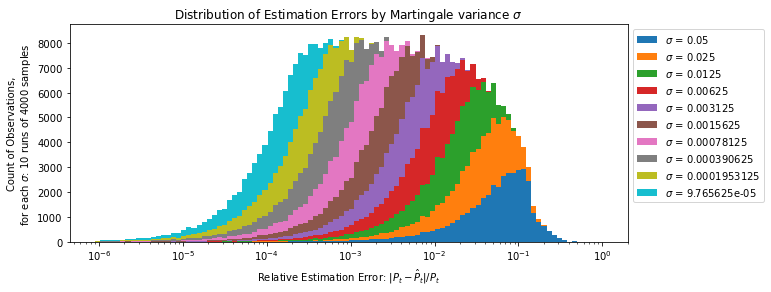

In [8]:
plt.subplots(figsize=(10,4))
plt.hist(sig_data2, bins=[.87**pow for pow in range(100,-1,-1)], stacked=True)
plt.xscale("log")
plt.legend(['$\sigma$ = '+str(st) for st in sys_params['sigma']], bbox_to_anchor=(1, 1), loc='upper left', ncol=1 )

plt.title('Distribution of Estimation Errors by Martingale variance $\sigma$')
plt.ylabel("""Count of Observations,
for each $\sigma$: 10 runs of 4000 samples """)
plt.xlabel('Relative Estimation Error: $|P_t - \hat P_t|/P_t$')
plt.show()

Distribution of relative estimation errors for various sigmas in the random walk.

In [9]:
from cadCAD import configs
configs.clear()

## Testing Different Kappa Parameters

We also can modify the kappa which we are using to observe differences in behavior patterns below.

In [11]:
from model_kappa import run as run_kappa
from model_kappa.sys_params import sys_params

df = run_kappa.run()
rdf = run_kappa.postprocessing(df)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: multi_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (4000, 9, 2, 5)
Execution Method: parallelize_simulations
Execution Mode: parallelized
Total execution time: 0.81s


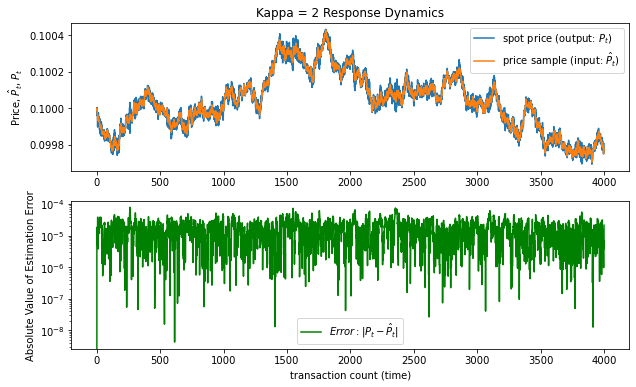

In [12]:
from model.parts.utils import response_plot
response_plot(rdf[rdf.kappa==2], "Kappa = 2")

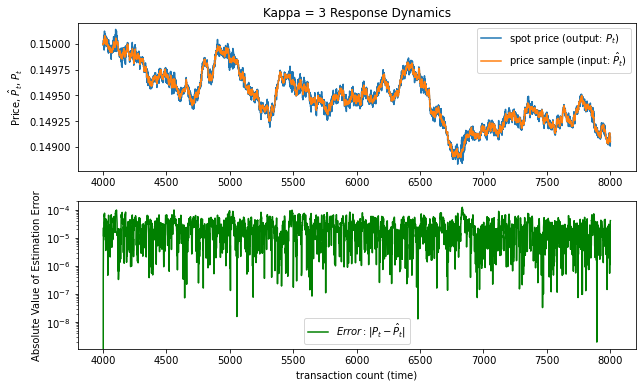

In [13]:
response_plot(rdf[rdf.kappa==3], "Kappa = 3")

## Conclusion

In this notebook, we have shared the experimental code used by Dr. Zargham's [Economic Games as Estimators](https://epub.wu.ac.at/7433/) paper. We have illustrated how to use different driving processes for running numerical simulations.